<a href="https://colab.research.google.com/github/jinxianyap/classification-models/blob/master/basic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gspread

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/WISE AI/Classification

  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1
Mounted at /gdrive
/gdrive/My Drive/WISE AI/Classification


In [ ]:
import os
import csv   
import json
import numpy as np
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from matplotlib.image import imread

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout,Conv2D,MaxPooling2D
from keras.optimizers import SGD,Adam
from keras.regularizers import l1
from sklearn.model_selection import KFold
from keras.models import model_from_json
from sklearn.metrics import classification_report

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

target_height = 200
target_width = 200
classes_dir = './classes/'

In [ ]:
def load_dataset():
  classes = os.listdir(classes_dir)
  train_photos, test_photos, train_labels, test_labels, train_paths, test_paths = list(), list(), list(), list(), list(), list()

  def get_encoding(class_name):
    return list(map(lambda c: 1 if c == class_name else 0, classes))

  for each in classes:
    i = 0;
    for image in os.listdir(classes_dir + each):
      output = get_encoding(each)
      photo = load_img(classes_dir + each + "/" + image, target_size=(target_height, target_width))
      photo = img_to_array(photo)

      if i > 2:
        train_photos.append(photo)
        train_labels.append(output)
        train_paths.append(each + "/" + image)
      else:
        test_photos.append(photo)
        test_labels.append(output)
        test_paths.append(each + "/" + image)
      i += 1;

  X_train = asarray(train_photos)
  y_train = asarray(train_labels)
  X_test = asarray(test_photos)
  y_test = asarray(test_labels)
  train_paths = asarray(train_paths)
  test_paths = asarray(test_paths)


  return classes, X_train, y_train, X_test, y_test, train_paths, test_paths

In [ ]:
def build_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(target_height, target_width, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(6, activation='softmax'))

  # opt = Adam(lr=0.001)
  opt = SGD(lr=0.01, momentum=0.5)
  model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
def train_model(model, dataX, dataY, testX, testY):
  datagen = ImageDataGenerator(rescale=1./255)
  testgen = ImageDataGenerator(rescale=1./255)

  history = model.fit(datagen.flow(dataX, dataY), epochs=20, validation_data=testgen.flow(testX, testY), verbose=1)
  _, acc = model.evaluate(testX, testY, verbose=0)
  print('> %.3f' % (acc * 100.0))

  return model, history, acc


In [ ]:
def plot_metrics(history):
  fig, (ax1, ax2) = pyplot.subplots(2)
  plot_loss(history, ax1)
  plot_accuracy(history, ax2)

def plot_loss(each, ax):
  ax.set_title('Cross Entropy Loss')
  ax.plot(each.history['loss'], color='blue', label='train')
  ax.plot(each.history['val_loss'], color='orange', label='test')

def plot_accuracy(each, ax):
  ax.set_title('Classification Accuracy')
  ax.plot(each.history['accuracy'], color='blue', label='train')
  ax.plot(each.history['val_accuracy'], color='orange', label='test')


In [ ]:
def decode(vals):
  return list(map(lambda x: list_to_num(x), vals))

def list_to_num(ls):
  res = 1
  for i in range(len(ls)):
    if ls[i] == 1:
      res = i
      break
  return res

def get_table_metrics(model, classes, testX, testY):
  print(classification_report(decode(testY), decode(model.predict(testX)), target_names=classes))
  return json.dumps(classification_report(decode(testY), decode(model.predict(testX)), target_names=classes, output_dict=True))

In [ ]:
def save_model(model):
  fd_model = os.open('./models/basic_classification.json', os.O_RDWR|os.O_CREAT) 
  model_json = model.to_json()
  os.write(fd_model, bytes(model_json, 'utf-8'))
  os.close(fd_model)

  model.save_weights("./weights/basic_classification.h5")
  print("Saved model to disk")

In [ ]:
def write_to_output(model, classes, dataX, dataY, paths, is_test):
  def next_available_row(worksheet):
    str_list = list(filter(None, worksheet.col_values(1)))
    return len(str_list)+1

  worksheet = gc.open('results').worksheet('basic')
  row = next_available_row(worksheet)

  for i in range(len(dataX)):
    first_row = str(row)
    worksheet.update_acell("A{}".format(first_row), 'basic')
    worksheet.update_acell("B{}".format(first_row), 'softmax')
    worksheet.update_acell("C{}".format(first_row), False)
    worksheet.update_acell("D{}".format(first_row), 'test' if is_test else 'train')
    worksheet.update_acell("E{}".format(first_row), 'classes')
    worksheet.update_acell("F{}".format(first_row), str(paths[i]))
    worksheet.update_acell("G{}".format(first_row), classes[list_to_num(dataY[i])])
    worksheet.update_acell("H{}".format(first_row), classes[decode(model.predict(dataX[i:i+1]))[0]])

    row += 1

  print('Written to output CSV')


Epoch 1/20
2/2 [==============================] - 0s 80ms/step - loss: 29.2892 - accuracy: 0.1731 - val_loss: 20.5372 - val_accuracy: 0.1667
Epoch 2/20
2/2 [==============================] - 0s 27ms/step - loss: 11.5219 - accuracy: 0.2500 - val_loss: 1.7108 - val_accuracy: 0.3889
Epoch 3/20
2/2 [==============================] - 0s 27ms/step - loss: 1.7078 - accuracy: 0.3462 - val_loss: 1.6171 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 0s 29ms/step - loss: 1.6147 - accuracy: 0.4423 - val_loss: 1.5162 - val_accuracy: 0.6111
Epoch 5/20
2/2 [==============================] - 0s 29ms/step - loss: 1.4541 - accuracy: 0.5962 - val_loss: 1.4115 - val_accuracy: 0.6667
Epoch 6/20
2/2 [==============================] - 0s 32ms/step - loss: 1.3332 - accuracy: 0.6923 - val_loss: 1.3074 - val_accuracy: 0.7222
Epoch 7/20
2/2 [==============================] - 0s 31ms/step - loss: 1.1800 - accuracy: 0.7115 - val_loss: 1.1961 - val_accuracy: 0.7222
Epoch 8/20
2/2 [========

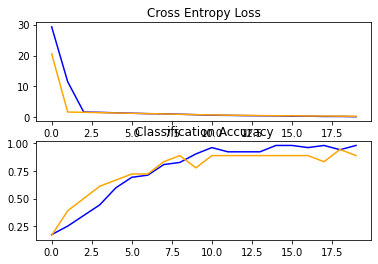

In [ ]:
classes, trainX, trainY, testX, testY, train_paths, test_paths = load_dataset()

model = build_model()

model, hists, accs = train_model(model, trainX, trainY, testX, testY)

plot_metrics(hists)

report = get_table_metrics(model, classes, testX, testY)

In [ ]:
save_model(model)

write_to_output(model, classes, trainX, trainY, train_paths, False)

Written to output CSV
